# Capstone Project: Stroke Risk Stratification by Classification #

This is a capstone project for Springboard's data science intensive track. The dataset used in this project is sourced from the data science competition sponsor by McKinsey analytics and held in a platform "Analytics Vidhya". 

The competition link can be found here [contest pages] (https://datahack.analyticsvidhya.com/contest/mckinsey-analytics-online-hackathon/).

** Problem Statement: ** a chain of hospitals in US collected annonymized pool of patients data for stroke classification. Stroke is one of critical disease which affects nearly 1 in 20 Americans and is a disease that affects arteries leading to and within the brain. A stroke occurs when a blood vessel that carries oxygen and nutrients to the brain is either blocked by a clot or ruptures. When that happens part of the brain cannot get the blood (and oxygen) it needs, so the brain cells in the affected portion die. The clients captured several lifestyle, health monitoring measurements and demographic factors about their annonymized patients. These include features like age, gender, health monitoring measurements (i.e., glucose level, body mass index) and lifestlye factors (i.e., smoking status, occupation type etc.). 

** Dataset: **
The data source was contributed by a chain of hospital clients based in US for McKinsey consulting firm. McKinsey hosted this dataset as open data science hack competition on Analytics Vidhya. The dataset consists of 12 features on anonymized patients including mixed variables (i.e., numerical and categorical) such as patient ID, gender, health conditions and other demographic features. The volume of dataset contains about 43,000 patient cases.

** Goal: ** 
To develop a classification model predicts patients at high risks of developing a stroke condition

** Results: **
80% of accurate predictions were made on test set of patient population using Majority Vote classifier.

** Risks: **
Model incorrectly identified with 20% of error (especially 9% of error being Type II error).

** Mitigation: **
Review identifed cases with a group of clinicians before any clinical decision making

** Next Steps for Future Work: **
* Collection of meaningful features.
* Model improvement: algorithms, resampling strategies and classifier designs (i.e., age-specific)

## Part A. Data Wrangling ##
Dataset required data cleansing and metadata formatting. Dataset was loaded onto Python as a dataframe. Dataset presented with a couple of problems such as missing data, outliers and imbalanced classes. In order to clean our dataset and prepared for classification modeling, data cleaning processes were executed. Processes were performed in a following order: feature imputation --> handling outliers --> format metadata types --> feature transformation (i.e., feature encoding). Once dataset was prepared, data exploration and machine learning model buidling exercises were performed.

In [1]:
# import all libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from matplotlib.colors import ListedColormap
from itertools import cycle
from sklearn.preprocessing import Imputer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import roc_curve, auc
from scipy import interp

# Read train data:
df = pd.read_csv('stroke_train.csv')
# Check dataframe info.:
df.info()

# Print the dataframe head:
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
id                   43400 non-null int64
gender               43400 non-null object
age                  43400 non-null float64
hypertension         43400 non-null int64
heart_disease        43400 non-null int64
ever_married         43400 non-null object
work_type            43400 non-null object
Residence_type       43400 non-null object
avg_glucose_level    43400 non-null float64
bmi                  41938 non-null float64
smoking_status       30108 non-null object
stroke               43400 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB
      id  gender   age  hypertension  heart_disease ever_married  \
0  30669    Male   3.0             0              0           No   
1  30468    Male  58.0             1              0          Yes   
2  16523  Female   8.0             0              0           No   
3  56543  Female  70.0             0      

### Check # of missing value counts and percentage ###

In [2]:
# Check number of missing values:
df.isnull().sum()

# Compute missing value stat.: pre-data cleansing
df_missing = df.isnull().sum()
df_missing = pd.DataFrame(df_missing)
df_missing.columns = ['missing_value_counts']
df_missing['missing_PCT'] = (df_missing['missing_value_counts']/43400)*100

# sort values by missing percent(%):
df_missing = df_missing.sort_values(by='missing_PCT',ascending=False)
df_missing

,missing_value_counts,missing_PCT
smoking_status,13292,30.626728
bmi,1462,3.368664
id,0,0.000000
gender,0,0.000000
age,0,0.000000
hypertension,0,0.000000
heart_disease,0,0.000000
ever_married,0,0.000000
work_type,0,0.000000
Residence_type,0,0.000000


### Compute Summary Statistics: pre-data cleansing ###
Computer summary statistics and report on numerical features only!

In [3]:
# Compute summary stat.: pre-data cleansing 
df_summary_pre = df.describe().T
# Reorder columns order in summary dataframe:
df_summary_pre = df_summary_pre[['count','min','max','mean','25%','50%','75%','std']]
# Keep only numerical (scale) features:
df_summary_pre = df_summary_pre.drop(['id','heart_disease','hypertension','stroke'])
df_summary_pre

,count,min,max,mean,25%,50%,75%,std
age,43400.0,0.08,82.00,42.217894,24.00,44.00,60.00,22.519649
avg_glucose_level,43400.0,55.00,291.05,104.482750,77.54,91.58,112.07,43.111751
bmi,41938.0,10.10,97.60,28.605038,23.20,27.70,32.90,7.770020


### Handling outliers with inter-quartile range (IQR) method ###
Outliers are the values that might potentialy skew the results on our modeling. Outliers were handled to acheived the best performances on our model as much as possible. In this training set, there were three numerical features age, BMI and average glucose level. 

To rule out any outliers, using interquartile range method was applied here. IQR is defined as IQR = Q3-Q1 where Q1 and Q3 are 25th and 75th percentile of your selected column/feature. Using this IQR, we computed lower bound (LB) and upper bound (UB) as defined as follow: LB = Q1 - 1.5 x IQR and UB = Q3 + 1.5 x IQR. 

From above definition, summary table was computed on all three numerical features. We can observed that the max. value on each of feature is greater than the upper bound value for average glucose and BMI. Therefore, presence of outliers were confirmed for BMI and average glucose level on beyond upper bound values.

In [4]:
# Handling outliers #
###############################################################################
# Compute IQR, LowerBound and UpperBound: age, bmi, glucose
df_summary_pre['IQR'] = df_summary_pre['75%'] - df_summary_pre['25%']
df_summary_pre['LB'] = df_summary_pre['25%']['age'] - 1.5*df_summary_pre['IQR']
df_summary_pre['UB'] = df_summary_pre['75%']['age'] + 1.5*df_summary_pre['IQR']

# Create a dataframe for detecting outliers:
df_outliers = df_summary_pre[['LB','min','UB','max']]
# Print outliers detection dataframe:
df_outliers

,LB,min,UB,max
age,-30.000,0.08,114.000,82.00
avg_glucose_level,-27.795,55.00,111.795,291.05
bmi,9.450,10.10,74.550,97.60


### Removal of outliers and drop useless feature ###
Before we remove any outliers using these two features, we tested how many observations were affected.
This is critical because while removing outliers we want to preserve positive "stroke cases" as much as possible. We can think of classification model as cost function. More true positive cases you have, better for training a model and make good predictions on future incoming patient cases (i.e., stroke predictions).

In [5]:
# Based on above results, outliers exist beyond UB values of bmi & avg_glucose_level
# Test outliers removal: X > upperbound of bmi values: removes 880 rows
df.drop(df[df['bmi'] > df_outliers['UB']['bmi']].index)
# Test outliers removal: X > upperbound of avg_glucose_level values: removes 4978 rows
df.drop(df[df['avg_glucose_level'] > df_outliers['UB']['avg_glucose_level']].index)

# Remove outliers using "bmi" upperbound:
df = df.drop(df[df['bmi'] > df_outliers['UB']['bmi']].index)

# Drop 'id' column from a dataframe: meaningless
df = df.drop(['id'], axis=1)

### Feature Encoding ###
Feature encoding is a process where feature are encoded into right format. There are two types of feature encoding: ordinal and nominal feature encoding. Ordinal feature encoding is a type of encoding where feature actually contains information about "order" like increase or decrease in value (i.e., score level, date, etc). Whereas nominal feature encoding is a type of encoding where feature contains a class of label like gender (i.e., male or female). 

** Ordinal feature encoding: ** smoking_status. 
Smoking status is a feature where it has a order of smoking level progresses from never smoked to frequent smoker.

Thus, smoking status gets mapped into numerical values then gets printed after ordinal feature encoding for checking data consistency.

In [6]:
# Ordinal feature encoding #
# Define manual map: smoking_status
smoking_status_map = {'never smoked': 0,
                      'formerly smoked': 1,
                      'smokes': 2}

# Encode features with smoking_status_map:
df['smoking_status'] = df['smoking_status'].map(smoking_status_map)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,0.0,0
2,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,1.0,0
4,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


** Nominal feature encoding: ** hypertension and heart_disease.
These two feature(s) have meaning of different class labels being "Yes" or "No" but already pre-encoded as numerical value(s) being "1" or "0". The main reason why these feature getting re-encoded back into word string is for exploratory data analysis phase. It is best practice to keep data format consistent among same type of variable or feature like "ever_married" which is originally contained value as a string "Yes" or "No".

In [7]:
# Nominal feature encoding #
# Define manual map for hypertension and heart_disease:
hypertension_map = {0: 'No', 1: 'Yes'}
heart_disease_map = {0: 'No', 1: 'Yes'}

# Encode binary flag (0/1) as 'Yes or No' for consistency:
df['hypertension'] = df['hypertension'].map(hypertension_map)
df['heart_disease'] = df['heart_disease'].map(heart_disease_map)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,3.0,No,No,No,children,Rural,95.12,18.0,NaN,0
1,Male,58.0,Yes,No,Yes,Private,Urban,87.96,39.2,0.0,0
2,Female,8.0,No,No,No,Private,Urban,110.89,17.6,NaN,0
3,Female,70.0,No,No,Yes,Private,Rural,69.04,35.9,1.0,0
4,Male,14.0,No,No,No,Never_worked,Rural,161.28,19.1,NaN,0


### Data Splits & Feature Transformation ###
First, dataset was split into a set of input features and an output label (i.e., stroke).
Secondly, feature imputation step was performed to replace any missing values on different data types (i.e., continuous and ordinal feature). For example, "BMI" and "smoking_status" were replaced by median and mode respectively. Thirdly, feature engieering was performed on "age" feature to create two extra age-related features like "age_group" and "age_group_label". Finally, metadata formatting was done to ensure each feature for having a correct data type.

In [8]:
# Split inputs and output label #
# take label as a series
Y = df['stroke']
Y.columns = ['stroke']

# take inputs
# drop 'stroke' from df1 and take an array of values:
X = df.drop(['stroke'], axis=1).values

# Feature Imputation #
# import libraries
from sklearn.preprocessing import Imputer
###############################################################################
# Imputation: bmi (scale feature) by median
# Column index = 8
imputer = Imputer(missing_values = 'NaN', strategy = 'median', axis=0)
imputer = imputer.fit(X[:, 8:9])
X[:,8:9] = imputer.transform(X[:, 8:9])

# Imputation: smoking_status (ordinal feature) by mode
# Column index = 9
imputer = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis=0)
imputer = imputer.fit(X[:, 9:10])
X[:,9:10] = imputer.transform(X[:, 9:10])

# Prepare cleansed dataframe: 
###############################################################################
# Column indexes 
columnX = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status']

# Row indexes
idx = Y.index

# Cleansed dataframe:
X1 = pd.DataFrame(X, columns=columnX, index=idx)
# Concatenated X1 cleaned inputs and output label as new dataframe:
df_cleaned = pd.concat([X1, Y], axis=1)
# Check any missing values on a new dataframe:
df_cleaned.isnull().sum()

# Feature engineering: discretization on age for age_group & age_bin_label
###############################################################################
age_bins = [0, 30, 40, 50, 60, 70, 80, 90]
age_bin_labels = [1,2,3,4,5,6,7]

# Stratification: age_group #
###############################################################################
# Generate age_group and age_group_label
df_cleaned['age_group'] = pd.cut(np.array(df_cleaned['age']),bins=age_bins) 
df_cleaned['age_group_label'] = pd.cut(np.array(df_cleaned['age']),bins=age_bins, labels=age_bin_labels) 

# Convert data types for cleaned dataframe:
###############################################################################
df_cleaned['gender'] = df_cleaned['gender'].astype('category')
df_cleaned['age'] = df_cleaned['age'].astype(float)
df_cleaned['hypertension'] = df_cleaned['hypertension'].astype('category')
df_cleaned['heart_disease'] = df_cleaned['heart_disease'].astype('category')
df_cleaned['ever_married'] = df_cleaned['ever_married'].astype('category')
df_cleaned['work_type'] = df_cleaned['work_type'].astype('category')
df_cleaned['Residence_type'] = df_cleaned['Residence_type'].astype('category')
df_cleaned['avg_glucose_level'] = df_cleaned['avg_glucose_level'].astype(float)
df_cleaned['bmi'] = df_cleaned['bmi'].astype(float)

# Convert smoking_status to original string #
inv_smoking_status_map = {v: k for k, v in smoking_status_map.items()}
df_cleaned['smoking_status'] = df_cleaned['smoking_status'].map(inv_smoking_status_map)

## Part B. Exploratory Data Analysis ##

### EDA: cleaned training set ###
Data exploration was conducted on cleaned entire training set. The main goal of this phase is to explore any interesting relationships among features and identify which feature(s) are likely good predictors on predicting cases for stroke patients.

Following set of questions are asked as guidelines for the exploratory data analysis:
1. Can I count something interesting?
2. Can I find some trends (increase or decrease and any anomalies)?
3. Can I plot a bar chart or a histogram?
4. Can I make a scatter plot?

These set of guiding questions will help us to explore any insights and tells a compelling story about stroke risk stratifcation model on the cleaned dataset.

In [9]:
# Compute summary stat.: post-data cleansing 
df_stat_post = df_cleaned.describe().T
# Reorder columns order in summary dataframe
df_stat_post = df_stat_post[['count','min','max','mean','25%','50%','75%','std']]
# drop non-numerical and meaningless features
df_stat_post = df_stat_post.drop(['stroke'])
df_stat_post

,count,min,max,mean,25%,50%,75%,std
age,43390.0,0.08,82.00,42.219995,24.00,44.00,60.0000,22.519985
avg_glucose_level,43390.0,55.00,291.05,104.481528,77.54,91.58,112.0675,43.107079
bmi,43390.0,10.10,72.20,28.561007,23.40,27.70,32.6000,7.587731


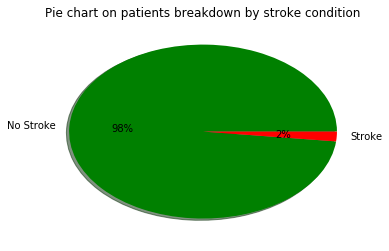

In [10]:
# Count frequencies and shows patients breakdown by stroke condition:
df_group_stroke = pd.DataFrame(df_cleaned.groupby('stroke')['stroke'].count())
df_group_stroke.columns = ['count']
plt.pie(df_group_stroke, labels=['No Stroke','Stroke'], autopct='%.0f%%', colors=['green','red'], shadow=True)
plt.title('Pie chart on patients breakdown by stroke condition')
plt.show()

### Count frequencies: on a stroke condition grouped by lifestyle and health indicators ###

In [11]:
# Count frequencies: demographic factors on a stroke condition
df_grp_gender = pd.DataFrame(df_cleaned.groupby(['stroke','gender'])['gender'].count())
df_grp_gender.columns = ['count']
df_grp_marital = pd.DataFrame(df_cleaned.groupby(['stroke','ever_married'])['ever_married'].count())
df_grp_marital.columns = ['count']
df_grp_residential = pd.DataFrame(df_cleaned.groupby(['stroke','Residence_type'])['Residence_type'].count())
df_grp_residential.columns = ['count']
df_grp_worktype = pd.DataFrame(df_cleaned.groupby(['stroke','work_type'])['work_type'].count())
df_grp_worktype.columns = ['count']

# Count frequencies: health indiator factors on a stroke condition
df_grp_smoking = pd.DataFrame(df_cleaned.groupby(['stroke','smoking_status'])['smoking_status'].count())
df_grp_smoking.columns = ['count']
df_grp_hypertension = pd.DataFrame(df_cleaned.groupby(['stroke','hypertension'])['hypertension'].count())
df_grp_hypertension.columns = ['count']
df_grp_heart = pd.DataFrame(df_cleaned.groupby(['stroke','heart_disease'])['heart_disease'].count())
df_grp_heart.columns = ['count']

### Frequency counts in percent for patient population: by demographic factors ###

In [12]:
# Proportion: a group of non-stroke patients by gender
df_grp_gender_0 = df_grp_gender.loc[0]
df_grp_gender_0['pct'] = (df_grp_gender_0/df_grp_gender_0.sum())*100
print(df_grp_gender_0['pct'])

# Proportion: a group of stroke patients by gender
df_grp_gender_1 = df_grp_gender.loc[1]
df_grp_gender_1['pct'] = (df_grp_gender_1/df_grp_gender_1.sum())*100
print(df_grp_gender_1['pct'])

gender
Female    59.213275
Male      40.760908
Other      0.025817
Name: pct, dtype: float64
gender
Female    55.0447
Male      44.9553
Name: pct, dtype: float64


In [13]:
# Proportion: a group of stroke patients by marital status
df_grp_marital_0 = df_grp_marital.loc[0]
df_grp_marital_0['pct'] = (df_grp_marital_0/df_grp_marital_0.sum())*100
print(df_grp_marital_0['pct'])

# Proportion: a group of stroke patients by marital status
df_grp_marital_1 = df_grp_marital.loc[1]
df_grp_marital_1['pct'] = (df_grp_marital_1/df_grp_marital_1.sum())*100
print(df_grp_marital_1['pct'])

ever_married
No     36.087967
Yes    63.912033
Name: pct, dtype: float64
ever_married
No     10.217114
Yes    89.782886
Name: pct, dtype: float64


In [14]:
# Proportion: a group of non-stroke patients by residential
df_grp_residential_0 = df_grp_residential.loc[0]
df_grp_residential_0['pct'] = (df_grp_residential_0/df_grp_residential_0.sum())*100
print(df_grp_residential_0['pct'])

# Proportion: a group of stroke patients by residential
df_grp_residential_1 = df_grp_residential.loc[1]
df_grp_residential_1['pct'] = (df_grp_residential_1/df_grp_residential_1.sum())*100
print(df_grp_residential_1['pct'])

Residence_type
Rural    49.886169
Urban    50.113831
Name: pct, dtype: float64
Residence_type
Rural    49.042146
Urban    50.957854
Name: pct, dtype: float64


In [15]:
# Proportion: a group of non-stroke patients by worktype
df_grp_worktype_0 = df_grp_worktype.loc[0]
df_grp_worktype_0['pct'] = (df_grp_worktype_0/df_grp_worktype_0.sum())*100
print(df_grp_worktype_0['pct'])

# Proportion: a group of stroke patients by worktype
df_grp_worktype_1 = df_grp_worktype.loc[1]
df_grp_worktype_1['pct'] = (df_grp_worktype_1/df_grp_worktype_1.sum())*100
print(df_grp_worktype_1['pct'])

work_type
Govt_job         12.556622
Never_worked      0.415425
Private          57.232380
Self-employed    15.354285
children         14.441289
Name: pct, dtype: float64
work_type
Govt_job         11.366539
Private          56.321839
Self-employed    32.056194
children          0.255428
Name: pct, dtype: float64


In [16]:
# Proporition: a group of non-stroke patients by smoking
df_grp_smoking_0 = df_grp_smoking.loc[0]
df_grp_smoking_0['pct'] = (df_grp_smoking_0/df_grp_smoking_0.sum())*100
print(df_grp_smoking_0['pct'])

# Proporition: a group of stroke patients by smoking
df_grp_smoking_1 = df_grp_smoking.loc[1]
df_grp_smoking_1['pct'] = (df_grp_smoking_1/df_grp_smoking_1.sum())*100
print(df_grp_smoking_1['pct'])

smoking_status
formerly smoked    17.067618
never smoked       67.845659
smokes             15.086723
Name: pct, dtype: float64
smoking_status
formerly smoked    28.224777
never smoked       54.789272
smokes             16.985951
Name: pct, dtype: float64


In [17]:
# Proporition: a group of non-stroke patients by hypertension
df_grp_hypertension_0 = df_grp_hypertension.loc[0]
df_grp_hypertension_0['pct'] = (df_grp_hypertension_0/df_grp_hypertension_0.sum())*100
print(df_grp_hypertension_0['pct'])

# Proporition: a group of stroke patients by hypertension
df_grp_hypertension_1 = df_grp_hypertension.loc[1]
df_grp_hypertension_1['pct'] = (df_grp_hypertension_1/df_grp_hypertension_1.sum())*100
print(df_grp_hypertension_1['pct'])

hypertension
No     90.952191
Yes     9.047809
Name: pct, dtype: float64
hypertension
No     74.457216
Yes    25.542784
Name: pct, dtype: float64


In [18]:
# Proporition: a group of non-stroke patients by heart_disease
df_grp_heart_0 = df_grp_heart.loc[0]
df_grp_heart_0['pct'] = (df_grp_heart_0/df_grp_heart_0.sum())*100
print(df_grp_heart_0['pct'])

# Proporition: a group of stroke patients by heart_disease
df_grp_heart_1 = df_grp_heart.loc[1]
df_grp_heart_1['pct'] = (df_grp_heart_1/df_grp_heart_1.sum())*100
print(df_grp_heart_1['pct'])

heart_disease
No     95.575844
Yes     4.424156
Name: pct, dtype: float64
heart_disease
No     77.394636
Yes    22.605364
Name: pct, dtype: float64


### Histogram: Continous Varaibles ###
Distribution of age, BMI and average glucose level on patient population. Distributions were plotted separately on same kind of figure for each group of stroke and non-stroke population.

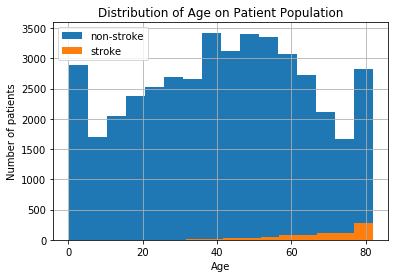

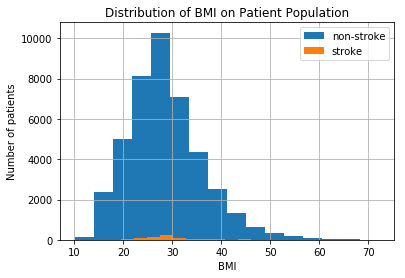

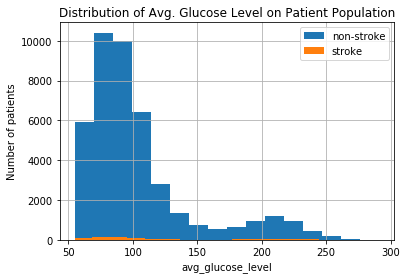

In [19]:
# Grouped dataframe by stroke label:
ag = df_cleaned.groupby('stroke')

# Visualization: continuous scale data #
###############################################################################
# Histogram: age
#plt.subplot(1,3,1)
ag['age'].hist(bins=16, label=ag['stroke'])
#df_cleaned['age'].hist(bins=16, facecolor = 'blue', edgecolor='black')
plt.title('Distribution of Age on Patient Population')
plt.xlabel('Age')
plt.ylabel('Number of patients')
plt.legend(('non-stroke','stroke'), loc='upper left')
plt.show()

# Histogram: bmi
#plt.subplot(1,3,2)
ag['bmi'].hist(bins=16, label=ag['stroke'])
#df_cleaned['bmi'].hist(bins=16, facecolor = 'red', edgecolor='black')
plt.title('Distribution of BMI on Patient Population')
plt.xlabel('BMI')
plt.ylabel('Number of patients')
plt.legend(('non-stroke','stroke'), loc='upper right')
plt.show()

# Histogram: avg_glucose_level
#plt.subplot(1,3,3)
ag['avg_glucose_level'].hist(bins=16, label=ag['stroke'])
#df_cleaned['avg_glucose_level'].hist(bins=20, facecolor = 'green', edgecolor='black')
plt.title('Distribution of Avg. Glucose Level on Patient Population')
plt.xlabel('avg_glucose_level')
plt.ylabel('Number of patients')
plt.legend(('non-stroke','stroke'), loc='upper right')
plt.show()

### Correlation Matrix: Training Set ###

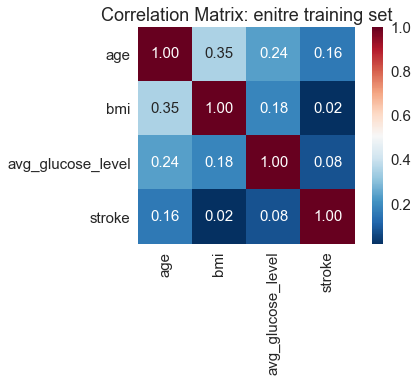

In [20]:
# Correlation Matrix Plot: entire dataset #
###############################################################################
# Column names of cleaned dataframe
cols = ['age','bmi','avg_glucose_level','stroke']

# Plot correlation matrix heatmap
plt.figure()
cm = np.corrcoef(df_cleaned[cols].values.T)
sns.set(font_scale = 1.5)
hm = sns.heatmap(cm, cmap='RdBu_r', cbar=True,
                 annot=True, square=True, fmt='.2f',
                 annot_kws={'size':15}, yticklabels=cols, xticklabels=cols)
plt.title('Correlation Matrix: enitre training set')
plt.show()

### EDA: stroke patients only ###
To have better understanding on stroke patients feature interaction, a separate sample only consists of stroke cases was prepared. Correlation matrix plot was plotted to show the trends among these three numerical features.

C:\Users\yoots\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\yoots\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


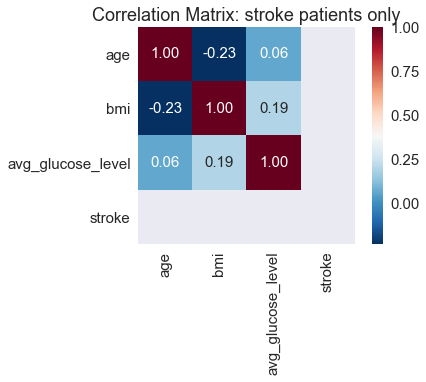

In [21]:
# Filtered dataframe by a stroke label: '0':non-stroke, '1':stroke #
###############################################################################
df_stroke_0 = df_cleaned[df_cleaned['stroke'] == 0] # only non-stroke patients
df_stroke_1 = df_cleaned[df_cleaned['stroke'] == 1] # only stroke patients

# Extracted columns for correlation matrix plot:
cols = ['age','bmi','avg_glucose_level','stroke']

# Correlation Matrix Plot #
# CM plot of stroke patients only:
plt.figure()
cm_stroke = np.corrcoef(df_stroke_1[cols].values.T)
sns.set(font_scale = 1.5)
_ = sns.heatmap(cm_stroke, cmap='RdBu_r', cbar=True,
                annot=True, square=True, fmt='.2f',
                annot_kws={'size':15}, yticklabels=cols, xticklabels=cols)
plt.title('Correlation Matrix: stroke patients only')
plt.show()

### Bar Charts: mean age of stroke patients factored by lifestyle indicators ###

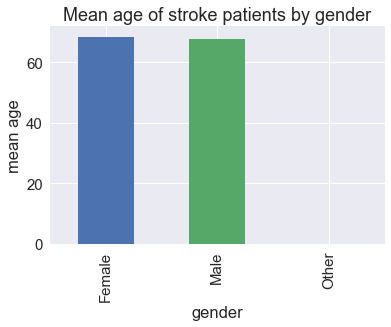

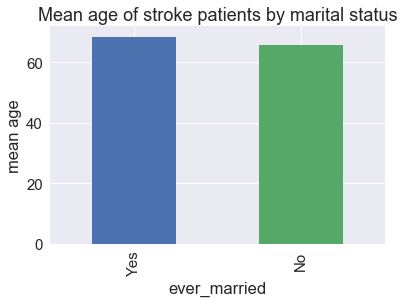

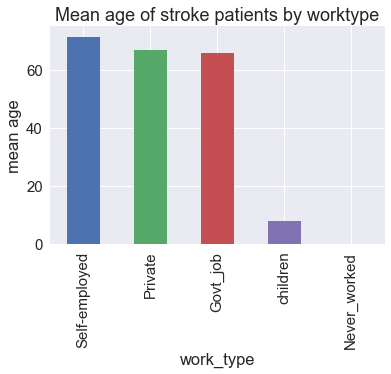

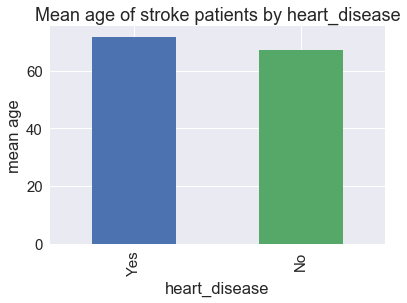

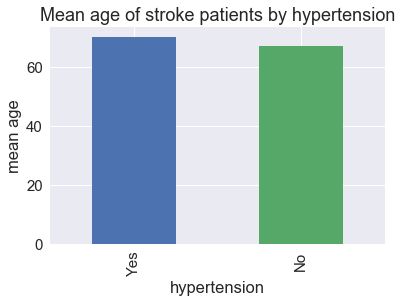

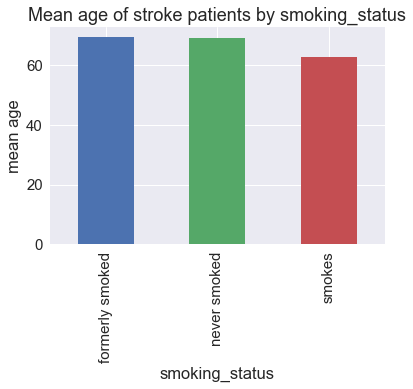

In [22]:
# Visualization: categorical data #
# Bar Charts: mean age of stroke patients by lifestyle factors
# Gender:
df_stroke_1.groupby('gender')['age'].mean().sort_values(ascending=False).plot(kind='bar').set_xlabel('gender')
plt.ylabel('mean age')
plt.title('Mean age of stroke patients by gender')
plt.show()

# Marital status:
plt.figure()
df_stroke_1.groupby('ever_married')['age'].mean().sort_values(ascending=False).plot(kind='bar').set_xlabel('ever_married')
plt.ylabel('mean age')
plt.title('Mean age of stroke patients by marital status')
plt.show()

# Work type:
plt.figure()
df_stroke_1.groupby('work_type')['age'].mean().sort_values(ascending=False).plot(kind='bar').set_xlabel('work_type')
plt.ylabel('mean age')
plt.title('Mean age of stroke patients by worktype')
plt.show()

# Bar Charts: mean age of stroke patients by health indicator factors
# heart_disease:
plt.figure()
df_stroke_1.groupby('heart_disease')['age'].mean().sort_values(ascending=False).plot(kind='bar').set_xlabel('heart_disease')
plt.ylabel('mean age')
plt.title('Mean age of stroke patients by heart_disease')
plt.show()

# hypertension:
plt.figure()
df_stroke_1.groupby('hypertension')['age'].mean().sort_values(ascending=False).plot(kind='bar').set_xlabel('hypertension')
plt.ylabel('mean age')
plt.title('Mean age of stroke patients by hypertension')
plt.show()

# smoking_status:
plt.figure()
df_stroke_1.groupby('smoking_status')['age'].mean().sort_values(ascending=False).plot(kind='bar').set_xlabel('smoking_status')
plt.ylabel('mean age')
plt.title('Mean age of stroke patients by smoking_status')
plt.show()

### Compute Summary Statistics: stroke vs. non-stroke patients ###

In [23]:
# Compute summary statistics: stroke vs. non-stroke patients #
###############################################################################
# Stroke patients only:
df_stroke_1_stat = df_stroke_1.describe().T
# Reorder columns order in summary dataframe
df_stroke_1_stat = df_stroke_1_stat[['count','min','max','mean','25%','50%','75%','std']]
# Drop 'stroke' column:
df_stroke_1_stat = df_stroke_1_stat.drop(['stroke'])
# Print summary stat.:
print(df_stroke_1_stat)

# Non-stroke patients only:
df_stroke_0_stat = df_stroke_0.describe().T
# Reorder columns order in summary dataframe
df_stroke_0_stat = df_stroke_0_stat[['count','min','max','mean','25%','50%','75%','std']]
# Drop 'stroke' column:
df_stroke_0_stat = df_stroke_0_stat.drop(['stroke'])
# Print summary stat.:
print(df_stroke_0_stat)

                   count    min     max        mean    25%     50%     75%  \
age                783.0   1.32   82.00   68.143448  60.00   71.00   79.00   
avg_glucose_level  783.0  55.01  271.74  129.582669  80.99  104.47  192.36   
bmi                783.0  14.30   56.60   29.480460  26.40   27.70   31.90   

                         std  
age                12.316537  
avg_glucose_level  59.734073  
bmi                 5.808726  
                     count    min     max        mean     25%    50%      75%  \
age                42607.0   0.08   82.00   41.743593  24.000  43.00   59.000   
avg_glucose_level  42607.0  55.00  291.05  104.020238  77.505  91.47  111.665   
bmi                42607.0  10.10   72.20   28.544110  23.400  27.70   32.700   

                         std  
age                22.385451  
avg_glucose_level  42.603841  
bmi                 7.615551  


### Age Stratification ###
* This will help us to stratify non-stroke and stroke patients sample with respect to their associated age groups.
* Age group: x<30, 30-40, 40-50, 50-60, 60-70, 70-80, 80-90

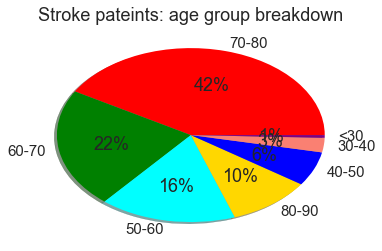

In [24]:
######################
# Age stratification #
######################
# Stroke patients age group dataframe:
df_grp_age_group_1 = pd.DataFrame(df_stroke_1.groupby('age_group')['age_group'].count().sort_values(ascending=False))
df_grp_age_group_1.columns = ['counts']
df_grp_age_group_1.index.name = 'age_group'
df_grp_age_group_1['pct'] = ((df_grp_age_group_1/df_grp_age_group_1.sum())*100).round(2)

# Plot a pie chart: age group composition on stroke patients
plt.pie(df_grp_age_group_1.loc[:,('counts')], labels=['70-80','60-70','50-60','80-90','40-50','30-40','<30'], 
        autopct='%.0f%%', colors=['red','green','cyan','gold','blue','salmon','purple'], shadow=True)
plt.title('Stroke pateints: age group breakdown')
plt.show()

In [25]:
# Age stratification on non-stroke patients sample #
###############################################################################
# Stratified by age_group_label:
df_stroke_0_age_grp1 = df_stroke_0[df_stroke_0['age_group_label'] == 1] # age: <30 
df_stroke_0_age_grp2 = df_stroke_0[df_stroke_0['age_group_label'] == 2] # age: 30-40
df_stroke_0_age_grp3 = df_stroke_0[df_stroke_0['age_group_label'] == 3] # age: 40-50
df_stroke_0_age_grp4 = df_stroke_0[df_stroke_0['age_group_label'] == 4] # age: 50-60
df_stroke_0_age_grp5 = df_stroke_0[df_stroke_0['age_group_label'] == 5] # age: 60-70
df_stroke_0_age_grp6 = df_stroke_0[df_stroke_0['age_group_label'] == 6] # age: 70-80
df_stroke_0_age_grp7 = df_stroke_0[df_stroke_0['age_group_label'] == 7] # age: 80-90

# Resampling: non-stroke patients proportion of age groups % #
####################################################################
# Age group counts index for stratification by minor class "stroke" %:
df_stroke_1_counts = df_stroke_1[['age_group','age_group_label']]
df_stroke_1_counts = pd.DataFrame(df_stroke_1_counts.groupby('age_group_label')['age_group'].count())
df_stroke_1_counts.columns = ['counts']

# Compute age group label proporiton % on stroke patients:
df_stroke_1_counts['age_group_pct'] = df_stroke_1_counts['counts']/df_stroke_1_counts['counts'].sum()

# Print the count index for each age group from stroke patients:
print(df_stroke_1_counts)

                 counts  age_group_pct
age_group_label                       
1                     4       0.005109
2                    21       0.026820
3                    50       0.063857
4                   129       0.164751
5                   174       0.222222
6                   326       0.416347
7                    79       0.100894


### Analysis on a balanced dataset with matching age distribution ###
To explain any hidden co-variates besides age, case control analysis was performed, where a sample of non-stroke patient population (n=783) was sampled by negative sub-sampling based on age distribution of stroke patient population counts (n=783).

In [26]:
# Downsampling on non-stroke patients by stroke patients proporition %
###############################################################################
sampled_0a_age_grp1 = resample(df_stroke_0_age_grp1, replace=True, 
                               n_samples=4,random_state=0)
sampled_0a_age_grp2 = resample(df_stroke_0_age_grp2, replace=True, 
                               n_samples=21,random_state=0)
sampled_0a_age_grp3 = resample(df_stroke_0_age_grp3, replace=True, 
                               n_samples=50,random_state=0)
sampled_0a_age_grp4 = resample(df_stroke_0_age_grp4, replace=True, 
                               n_samples=129,random_state=0)
sampled_0a_age_grp5 = resample(df_stroke_0_age_grp5, replace=True, 
                               n_samples=174,random_state=0)
sampled_0a_age_grp6 = resample(df_stroke_0_age_grp6, replace=True, 
                               n_samples=326,random_state=0)
sampled_0a_age_grp7 = resample(df_stroke_0_age_grp7, replace=True, 
                               n_samples=79,random_state=0)

# Concatentate downsampled majority class: "non-stroke" patients by all age groups
df_stroke_0a_downsampled = pd.concat([sampled_0a_age_grp1,sampled_0a_age_grp2,sampled_0a_age_grp3,
                                  sampled_0a_age_grp4,sampled_0a_age_grp5,sampled_0a_age_grp6,
                                  sampled_0a_age_grp7], axis=0)

# Conbine minority class: "stroke" patients with downsampled non-stroke patients
df_downsampled_stroke_0a = pd.concat([df_stroke_0a_downsampled,df_stroke_1],axis=0)

### Correlation Matrix: balanced dataset with matching age distribution ###
Resampling: down-sampled on majority class label (non-stroke)

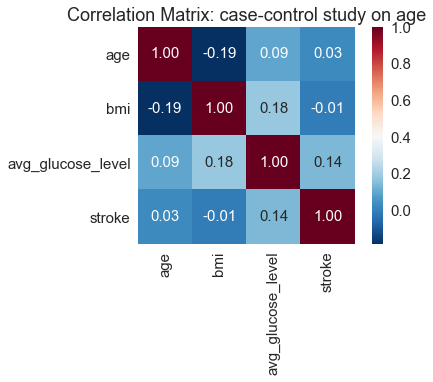

In [27]:
# Correlation Matrix Plot: age controlled downsampled set #
###############################################################################
# CM plot of downsampled majority: "0" non-stroke patients
cm_downsampled_stroke_0a = np.corrcoef(df_downsampled_stroke_0a[cols].values.T)
sns.set(font_scale = 1.5)
hm = sns.heatmap(cm_downsampled_stroke_0a, cmap='RdBu_r', cbar=True,
                 annot=True, square=True, fmt='.2f',
                 annot_kws={'size':15}, yticklabels=cols, xticklabels=cols)
plt.title('Correlation Matrix: case-control study on age')
plt.show()

### Analysis on Randomized Down-sampling for Non-stroke Patient Population ###
* From above case control analysis, we were able to identify other hidden co-variates (i.e., bmi, avg. glucose level) besides age. Now, we performed resampling on a group of non-stroke patients by randomized negative sub-sampling. The dataset was highly imbalanced where majority of cases were non-stroke (98%) and only 2% were stroke cases. 
* Applying resampling (i.e., negative sub-sampling) was required to address this issue. If model is constructed with high imbalanced dataset, model would not be useful at all. As likely the model will be good at making predictions on future incoming cases as non-stroke patients most of time. Think of classifier as a cost sensitive function where if model gets fed with more stroke cases, it will be good at identifying cases as stroke patients.
* After downsampling, the resampled dataset had equal ratio of stroke and non-stroke cases with a sample size (n=1566).

In [28]:
# Resampling: non-stroke patients proportion of age groups % #
####################################################################
# Age group counts index for stratification by major class "non-stroke" %:
df_stroke_0_counts = df_stroke_0[['age_group','age_group_label']]
df_stroke_0_counts = pd.DataFrame(df_stroke_0_counts.groupby('age_group_label')['age_group'].count())
df_stroke_0_counts.columns = ['counts']

# Compute age group label proporiton % on non-stroke patients:
df_stroke_0_counts['age_group_pct'] = df_stroke_0_counts['counts']/df_stroke_0_counts['counts'].sum()

# Print the count index for each age group from non-stroke patients:
print(df_stroke_0_counts)

                 counts  age_group_pct
age_group_label                       
1                 14228       0.333936
2                  5496       0.128993
3                  6390       0.149975
4                  6562       0.154012
5                  5055       0.118642
6                  4066       0.095430
7                   810       0.019011


In [29]:
# Downsampling on non-stroke patients by non-stroke patients proporition %
###############################################################################
sampled_0b_age_grp1 = resample(df_stroke_0_age_grp1, replace=True, 
                               n_samples=261,random_state=0)
sampled_0b_age_grp2 = resample(df_stroke_0_age_grp2, replace=True, 
                               n_samples=101,random_state=0)
sampled_0b_age_grp3 = resample(df_stroke_0_age_grp3, replace=True, 
                               n_samples=117,random_state=0)
sampled_0b_age_grp4 = resample(df_stroke_0_age_grp4, replace=True, 
                               n_samples=121,random_state=0)
sampled_0b_age_grp5 = resample(df_stroke_0_age_grp5, replace=True, 
                               n_samples=93,random_state=0)
sampled_0b_age_grp6 = resample(df_stroke_0_age_grp6, replace=True, 
                               n_samples=75,random_state=0)
sampled_0b_age_grp7 = resample(df_stroke_0_age_grp7, replace=True, 
                               n_samples=15,random_state=0)

# Concatentate downsampled majority class: "non-stroke" patients by all age groups
df_stroke_0b_downsampled = pd.concat([sampled_0b_age_grp1,sampled_0b_age_grp2,sampled_0b_age_grp3,
                                  sampled_0b_age_grp4,sampled_0b_age_grp5,sampled_0b_age_grp6,
                                  sampled_0b_age_grp7], axis=0)

# Conbine minority class: "stroke" patients with downsampled non-stroke patients
df_downsampled_stroke_0b = pd.concat([df_stroke_0b_downsampled,df_stroke_1],axis=0)

# Remove age group, age group label
df_downsampled_stroke_0b = df_downsampled_stroke_0b.drop(['age_group','age_group_label'], axis=1)

### Correlation Matrix: randomized downsampling for non-stroke patients population ###

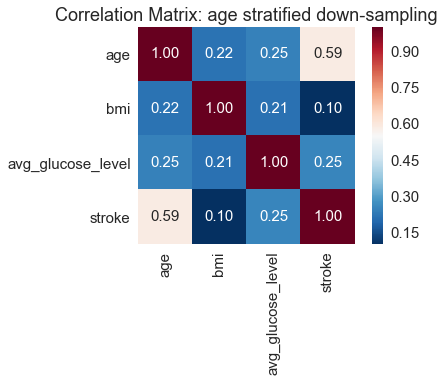

In [30]:
# Correlation Matrix Plot: age stratified random downsampled set #
###############################################################################
# CM plot of downsampled majority: "0" non-stroke patients by minority class %
cm_downsampled_stroke_0b = np.corrcoef(df_downsampled_stroke_0b[cols].values.T)
sns.set(font_scale = 1.5)
hm = sns.heatmap(cm_downsampled_stroke_0b, cmap='RdBu_r', cbar=True,
                 annot=True, square=True, fmt='.2f',
                 annot_kws={'size':15}, yticklabels=cols, xticklabels=cols)
plt.title('Correlation Matrix: age stratified down-sampling')
plt.show()

## Linear Regression Analysis: Balanced Dataset ##

In [31]:
# Split age and glucose features into two groups of different population:
# Stroke patients group:
age_1a = df_downsampled_stroke_0b[df_downsampled_stroke_0b['stroke'] == 1]['age']
glucose_1a = df_downsampled_stroke_0b[df_downsampled_stroke_0b['stroke'] == 1]['avg_glucose_level']

# Non-stroke patients group: 
age_0a = df_downsampled_stroke_0b[df_downsampled_stroke_0b['stroke'] == 0]['age']
glucose_0a = df_downsampled_stroke_0b[df_downsampled_stroke_0b['stroke'] == 0]['avg_glucose_level']

# Married patients group:
age_1b = df_downsampled_stroke_0b[df_downsampled_stroke_0b['ever_married'] == 'Yes']['age']
glucose_1b = df_downsampled_stroke_0b[df_downsampled_stroke_0b['ever_married'] == 'Yes']['avg_glucose_level']

# Single patients group: 
age_0b = df_downsampled_stroke_0b[df_downsampled_stroke_0b['ever_married'] == 'No']['age']
glucose_0b = df_downsampled_stroke_0b[df_downsampled_stroke_0b['ever_married'] == 'No']['avg_glucose_level']

In [32]:
# Pearson correlation coefficient:
def pearson_r(x,y):
    corr_mat = np.corrcoef(x,y)
    return corr_mat[0,1]

# Compute correlation coefficient #
# r: age vs. bmi [stroke population]
r1a = pearson_r(age_1a,glucose_1a)
print(r1a)

# r: age vs. bmi [non-stroke population]
r0a = pearson_r(age_0a,glucose_0a)
print(r0a)

# r: age vs. bmi [married population]
r1b = pearson_r(age_1b,glucose_1b)
print(r1b)

# r: age vs. bmi [single population]
r0b = pearson_r(age_0b,glucose_0b)
print(r0b)

0.0630598520692
0.198711160812
0.167204866406
0.299844403386


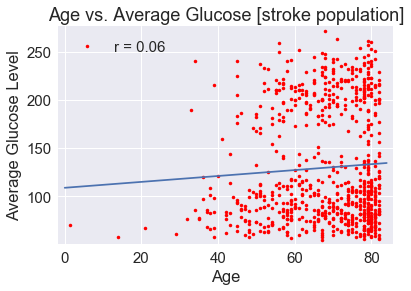

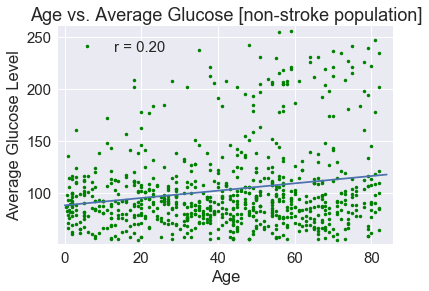

In [33]:
#########################
# Conditioned by stroke #
#########################

# Plot a scatter plot: age vs. bmi [stroke population]
###############################################################################
plt.figure()
#plt.subplots_adjust(wspace=0.5)

#plt.subplot(1,2,1)
_ = plt.plot(age_1a, glucose_1a, 'r--', label='r = %.2f' % r1a, 
             marker='.',linestyle='none', color='red')
plt.margins(0.02)
_ = plt.legend(loc='upper left')
_ = plt.xlabel('Age')
_ = plt.ylabel('Average Glucose Level')
_ = plt.title('Age vs. Average Glucose [stroke population]')

# Draw a linear regression:
a,b = np.polyfit(age_1a,glucose_1a,1)

# Theoretical best line of fit:
x = np.array([0,84])
y = a*x + b

_ = plt.plot(x,y)
plt.show()

# Plot a scatter plot: age vs. bmi [non-stroke population]
###############################################################################
#plt.subplot(1,2,2)
_ = plt.plot(age_0a, glucose_0a, 'r--', label='r = %.2f' % r0a, 
             marker='.',linestyle='none', color='green')
plt.margins(0.02)
_ = plt.legend(loc='upper left')
_ = plt.xlabel('Age')
_ = plt.ylabel('Average Glucose Level')
_ = plt.title('Age vs. Average Glucose [non-stroke population]')

# Draw a linear regression:
a,b = np.polyfit(age_0a,glucose_0a,1)

# Theoretical best line of fit:
x = np.array([0,84])
y = a*x + b

_ = plt.plot(x,y)
plt.show()

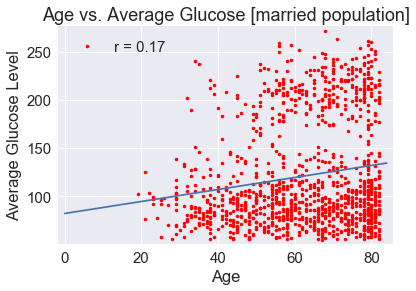

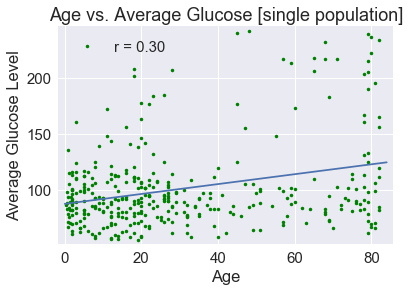

In [34]:
#################################
# Conditioned by marital status #
#################################

# Plot a scatter plot: age vs. bmi [married population]
###############################################################################
plt.figure()
#plt.subplots_adjust(wspace=0.5)

#plt.subplot(1,2,1)
_ = plt.plot(age_1b, glucose_1b, 'r--', label='r = %.2f' % r1b, 
             marker='.',linestyle='none', color='red')
plt.margins(0.02)
_ = plt.legend(loc='upper left')
_ = plt.xlabel('Age')
_ = plt.ylabel('Average Glucose Level')
_ = plt.title('Age vs. Average Glucose [married population]')

# Draw a linear regression:
a,b = np.polyfit(age_1b,glucose_1b,1)

# Theoretical best line of fit:
x = np.array([0,84])
y = a*x + b

_ = plt.plot(x,y)
plt.show()

# Plot a scatter plot: age vs. bmi [single population]
###############################################################################
#plt.subplot(1,2,2)
_ = plt.plot(age_0b, glucose_0b, 'r--', label='r = %.2f' % r0b, 
             marker='.',linestyle='none', color='green')
plt.margins(0.02)
_ = plt.legend(loc='upper left')
_ = plt.xlabel('Age')
_ = plt.ylabel('Average Glucose Level')
_ = plt.title('Age vs. Average Glucose [single population]')

# Draw a linear regression:
a,b = np.polyfit(age_0b,glucose_0b,1)

# Theoretical best line of fit:
x = np.array([0,84])
y = a*x + b

_ = plt.plot(x,y)
plt.show()

## Part C. Machine Learning Modeling: Classificaion ##

### Dummy Variable Encoding: nominal features ###
Dummy variable encoding on nominal feature allows to create a separate column on each feature and its value are only encoded "0" or "1". This dummy indicator get interpreted well to the ML models for making accurate prediction. Also to reduce any potential biases of having multi-colinearity, each feature's first encoded dummy variable must be dropped to avoid dummy variable trap (i.e., where independent variables are highly inter-correlated with each other as one predictor can be predicted from other of similar variables: gender_female vs. gender_male vs. gender_other).

In [35]:
# Perform dummy variable encoding on nominal features #
###############################################################################
# Drop first dummy variable to avoid dummy variable trap on each converted feature!
df2 = pd.get_dummies(df_downsampled_stroke_0b[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
                         'work_type', 'Residence_type', 'avg_glucose_level', 'bmi','smoking_status']],
                          drop_first=True)

# Concatenated with a stroke label on transformed dataframe: 
df2 = pd.concat([df2, df_downsampled_stroke_0b['stroke']], axis=1)

# Display new class counts:
print(df2.stroke.value_counts())

# new downsampled df column names:
_ = df2.columns
print(_)

1    783
0    783
Name: stroke, dtype: int64
Index(['age', 'avg_glucose_level', 'bmi', 'gender_Male', 'gender_Other',
       'hypertension_Yes', 'heart_disease_Yes', 'ever_married_Yes',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban',
       'smoking_status_never smoked', 'smoking_status_smokes', 'stroke'],
      dtype='object')


### Split on input features and output label ###
For cardiac stroke cases risk stratifcation problem, following set of classifiers were tested which included logistic regression, decision tree, random forest and gradient boosting (XGBoost).

After each model construction, RandomizedSearchCV module was applied to tune hyperparameters (i.e., C, n_estimators, etc.) on each model. This boosted model helps us to achieve the best desired performance for making predictions on patients with high risks of developing a stroke.

In [36]:
# QA check on input features/class label #
###############################################################################
# Re-define input features:
X = df2.iloc[:, :-1].values
# Reduced output feature (label): stroke
y = df2['stroke'].values
# Print unique labels for stroke condition:
print('Class labels:', np.unique(y))

Class labels: [0 1]


### Data Partition & Feature Scaling ###

In [37]:
###############################################################################
# General: data parition - train vs. test set
# Use built-in stratify mode to ensure equal % label splits
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 1/4, random_state = 0, stratify=y)

# Check label counts on the split set:
print('Class labels counts in total:', np.bincount(y))
print('Class labels counts in train set:', np.bincount(y_train))
print('Class labels counts in test set:', np.bincount(y_test)) 

# Feature Scaling: 
sc_X = StandardScaler() 
X_train_std = sc_X.fit_transform(X_train) 
X_test_std = sc_X.fit_transform(X_test)    

Class labels counts in total: [783 783]
Class labels counts in train set: [587 587]
Class labels counts in test set: [196 196]


### Model 1: Logistic Regression ###

In [38]:
################################
# Model 1: Logistic Regression #
################################
# Feature Selection: Recursive Feature Elimination #
###############################################################################
# Using Logistic Regression: 
lr = LogisticRegression(random_state=0)
from sklearn.feature_selection import RFE
rfe = RFE(lr, 2) 
rfe.fit(X_train_std, y_train)
print("Num Features: %d" % rfe.n_features_)
print("Selected Features: %s" % rfe.support_)
print("Feature Ranking: %s" % rfe.ranking_)

Num Features: 2
Selected Features: [ True False False False False False  True False False False False False
 False False False]
Feature Ranking: [ 1  2 11 10 14  8  1 12  7  9  5  6 13  3  4]


In [39]:
# Feature Selection by LogisticReg + RFE #
###############################################################################
# Reduced features: age, heart_disease_yes 
X_lr = X_train_std[:, [0,7]]
y_lr = y_train

# K-fold Cross-validation: Stratified #
# Logistic Regression:
skf = StratifiedKFold(n_splits=4, random_state=0)
for train_index, val_index in skf.split(X_lr, y_lr):
#   print("TRAIN:", train_index,  "VALIDATE:", val_index)
    X_train_lr, X_val_lr = X_lr[train_index], X_lr[val_index]
    y_train_lr, y_val_lr = y_lr[train_index], y_lr[val_index]

In [40]:
# Model: Logistic Regression
lr_cv = LogisticRegression(C=0.1,penalty='l1',random_state=0)
lr_cv.fit(X_train_lr, y_train_lr)

# Hyperparameters Tuning:
###############################################################################
# RandomizedSearchCV: LogisticRegression #
# Create hyperparameter options:
param_dist = dict(C=randint(2,100), penalty=['l1','l2'])
random_search = RandomizedSearchCV(estimator=lr_cv, param_distributions=param_dist,
                                   random_state=0, n_iter=100, cv=4)
#random_search_lr = random_search.fit(X_train_lr, y_train_lr)
random_search_lr = random_search.fit(X_val_lr, y_val_lr)

# View best hyperparameters
print('Best Penalty:', random_search_lr.best_estimator_.get_params()['penalty'])
print('Best C:', random_search_lr.best_estimator_.get_params()['C'])

# Model prediction: hold-out test set
X_test_lr = X_test_std[:, [0,7]]
y_pred_test_lr = random_search_lr.predict(X_test_lr)  

Best Penalty: l2
Best C: 46


### Model 2: Decision Tree ###

 1) age                            0.862503
 2) avg_glucose_level              0.067069
 3) heart_disease_Yes              0.055163
 4) smoking_status_never smoked    0.008242
 5) bmi                            0.007024
 6) smoking_status_smokes          0.000000
 7) Residence_type_Urban           0.000000
 8) work_type_children             0.000000
 9) work_type_Self-employed        0.000000
10) work_type_Private              0.000000
11) work_type_Never_worked         0.000000
12) ever_married_Yes               0.000000
13) hypertension_Yes               0.000000
14) gender_Other                   0.000000
15) gender_Male                    0.000000


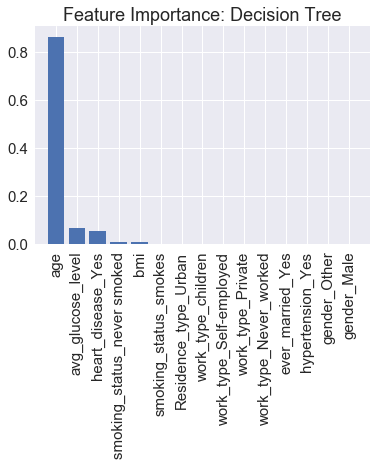

In [41]:
####################################
# Model 2: DecisionTree Classifier #
####################################
# Feature Selection: Feature Importance #
###############################################################################
# Using a Decision Tree:
tree = DecisionTreeClassifier(criterion='gini',
                                max_depth=4,
                                random_state=0)
feat_labels = df2.columns[:-1]
tree.fit(X_train_std, y_train)
importances = tree.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train_std.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]],
                            importances[indices[f]]))

plt.title('Feature Importance: Decision Tree')
plt.bar(range(X_train_std.shape[1]),
        importances[indices],
        align='center')
plt.xticks(range(X_train_std.shape[1]),
           feat_labels[indices], rotation=90)
plt.xlim(-1, X_train_std.shape[1])
plt.show()  

In [42]:
# Feature Selection by DT Classifier: age and avg_glucose_level
X_dt = X_train_std[:, [0,1]]
y_dt = y_train

# K-fold Cross-validation: Stratified #
# DecisionTree Classifier:
for train_index, val_index in skf.split(X_dt, y_dt):
#   print("TRAIN:", train_index,  "VALIDATE:", val_index)
    X_train_dt, X_val_dt = X_dt[train_index], X_dt[val_index]
    y_train_dt, y_val_dt = y_dt[train_index], y_dt[val_index]

In [43]:
# Model: DecisionTree [cross-validated & std. train set]
tree_cv = DecisionTreeClassifier(criterion='gini', max_depth=8,
                                min_samples_split=2, min_samples_leaf=2,
                                random_state=0)
tree_cv.fit(X_train_dt, y_train_dt)

# Hyperparameters Tuning:
###############################################################################
# Create hyperparameter options:
param_dist_dt = {"criterion": ["gini", "entropy"],
                  "max_depth": randint(10, 100),
                  "max_leaf_nodes": randint(10, 20),
                  "min_samples_split": randint(2, 10),
                  "min_samples_leaf": randint(2, 10)}
random_search = RandomizedSearchCV(estimator=tree_cv, param_distributions=param_dist_dt,
                                   random_state=0, n_iter=100, cv=4)
random_search_dt = random_search.fit(X_val_dt, y_val_dt)

# View best hyperparameters
print('Best min_samples_split:', random_search_dt.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', random_search_dt.best_estimator_.get_params()['min_samples_leaf'])
print('Best max_depth:', random_search_dt.best_estimator_.get_params()['max_depth'])

# Model prediction: hold-out test set
X_test_dt = X_test_std[:, [0,1]]
y_pred_test_dt = random_search_dt.predict(X_test_dt)   

Best min_samples_split: 6
Best min_samples_leaf: 2
Best max_depth: 97


### Model 3: Random Forest ###

 1) age                            0.339930
 2) avg_glucose_level              0.202932
 3) bmi                            0.192362
 4) heart_disease_Yes              0.039736
 5) ever_married_Yes               0.037956
 6) work_type_children             0.028460
 7) hypertension_Yes               0.027563
 8) Residence_type_Urban           0.026616
 9) smoking_status_never smoked    0.025206
10) gender_Male                    0.024976
11) work_type_Self-employed        0.022105
12) work_type_Private              0.019245
13) smoking_status_smokes          0.012728
14) work_type_Never_worked         0.000185
15) gender_Other                   0.000000


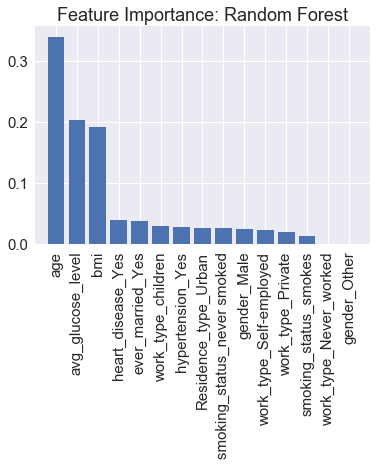

In [44]:
####################################
# Model 3: RandomForest Classifier #
####################################
# Feature Selection: Feature Importance #
###############################################################################
# Using a Random Forest:
forest = RandomForestClassifier(criterion='gini',
                                n_estimators=25,
                                random_state=0,
                                n_jobs=1)
feat_labels = df2.columns[:-1]
forest.fit(X_train_std, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train_std.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]],
                            importances[indices[f]]))

plt.figure()    
plt.title('Feature Importance: Random Forest')
plt.bar(range(X_train_std.shape[1]),
        importances[indices],
        align='center')
plt.xticks(range(X_train_std.shape[1]),
           feat_labels[indices], rotation=90)
plt.xlim(-1, X_train_std.shape[1])
plt.show() 

In [45]:
# Feature Selection by RF Classifier: age and avg_glucose_level
X_rf = X_train_std[:, [0,1]]
y_rf = y_train

# K-fold Cross-validation: Stratified #
# RandomForest Classifier:
for train_index, val_index in skf.split(X_rf, y_rf):
#   print("TRAIN:", train_index,  "VALIDATE:", val_index)
    X_train_rf, X_val_rf = X_rf[train_index], X_rf[val_index]
    y_train_rf, y_val_rf = y_rf[train_index], y_rf[val_index]

In [46]:
# Model: RandomForest [cross-validated & std. train set]
forest_cv = RandomForestClassifier(criterion='gini',n_estimators=50,
                                max_depth=1, min_samples_split=2,
                                random_state=0, n_jobs=1)
forest_cv.fit(X_train_rf, y_train_rf)

# Hyperparameters Tuning:
###############################################################################
# Create hyperparameter options:
param_dist_rf = {"n_estimators": randint(20, 200), 
                 "max_depth": randint(10, 100),
                  "min_samples_split": randint(2, 10),
                  "min_samples_leaf": randint(2, 10),
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"]}
random_search = RandomizedSearchCV(estimator=forest_cv, param_distributions=param_dist_rf,
                                   random_state=0, n_iter=100, cv=4)
random_search_rf = random_search.fit(X_val_rf, y_val_rf)

# View best hyperparameters
print('Best n_estimators:', random_search_rf.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', random_search_rf.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', random_search_rf.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', random_search_rf.best_estimator_.get_params()['min_samples_leaf'])

# Model prediction: hold-out test set
X_test_rf = X_test_std[:, [0,1]]
y_pred_test_rf = random_search_rf.predict(X_test_rf)

Best n_estimators: 142
Best max_depth: 78
Best min_samples_split: 5
Best min_samples_leaf: 8


### Model 4: XGBoost ###

 1) bmi                            0.308703
 2) avg_glucose_level              0.307061
 3) age                            0.198686
 4) Residence_type_Urban           0.031199
 5) gender_Male                    0.022989
 6) work_type_Self-employed        0.019704
 7) heart_disease_Yes              0.019704
 8) smoking_status_smokes          0.018062
 9) work_type_Private              0.018062
10) smoking_status_never smoked    0.016420
11) work_type_children             0.013136
12) ever_married_Yes               0.013136
13) hypertension_Yes               0.013136
14) work_type_Never_worked         0.000000
15) gender_Other                   0.000000


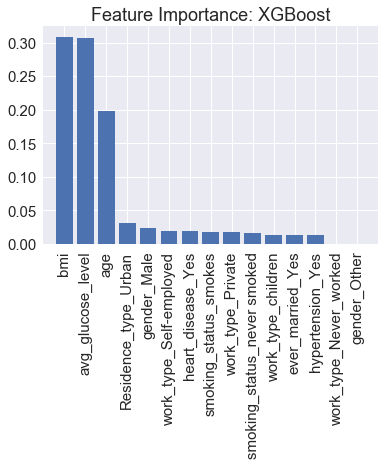

In [47]:
####################################
# Model 4: XGBoost Classifier #
####################################
# Feature Selection: Feature Importance #
###############################################################################
# Using a XGBoost:
xgb = XGBClassifier(n_estimators=100,
                    random_state=0,
                    n_jobs=1,
                    learning_rate=0.2)
feat_labels = df2.columns[:-1]
xgb.fit(X_train_std, y_train)
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train_std.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]],
                            importances[indices[f]]))

plt.figure()    
plt.title('Feature Importance: XGBoost')
plt.bar(range(X_train_std.shape[1]),
        importances[indices],
        align='center')
plt.xticks(range(X_train_std.shape[1]),
           feat_labels[indices], rotation=90)
plt.xlim(-1, X_train_std.shape[1])
plt.show()     

In [48]:
# Feature Selection by XGB Classifier: age and bmi
X_xgb = X_train_std[:, [0,2]]
y_xgb = y_train

# K-fold Cross-validation: Stratified #
# XGB Classifier:
for train_index, test_index in skf.split(X_xgb, y_xgb):
#   print("TRAIN:", train_index,  "VALIDATE:", val_index)
    X_train_xgb, X_val_xgb = X_xgb[train_index], X_xgb[val_index]
    y_train_xgb, y_val_xgb = y_xgb[train_index], y_xgb[val_index]

In [49]:
# Model: XGBClassifier [cross-validated & std. train set]
xgb_cv = XGBClassifier(n_estimators=50, learning_rate=0.2,
                       max_depth=1, random_state=0, n_jobs=1)
xgb_cv.fit(X_train_xgb, y_train_xgb)

# Hyperparameters Tuning:
###############################################################################
# Create hyperparameter options:
param_dist_xgb = {"n_estimators": randint(20, 200), 
                 "max_depth": randint(10, 100),
                  "learning_rate": np.random.uniform(0,1,10),
                  "objective": ['binary:logistic','reg:linear'],
                  "booster": ['gbtree','gblinear']}
random_search = RandomizedSearchCV(estimator=xgb_cv, param_distributions=param_dist_xgb,
                                   random_state=0, n_iter=100, cv=4)
random_search_xgb = random_search.fit(X_val_xgb, y_val_xgb)

# View best hyperparameters
print('Best n_estimators:', random_search_xgb.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', random_search_xgb.best_estimator_.get_params()['max_depth'])
print('Best learning_rate:', random_search_xgb.best_estimator_.get_params()['learning_rate'])
print('Best objective:', random_search_xgb.best_estimator_.get_params()['objective'])
print('Best booster:', random_search_xgb.best_estimator_.get_params()['booster'])

# Model prediction: hold-out test set
X_test_xgb = X_test_std[:, [0,2]]
y_pred_test_xgb = random_search_xgb.predict(X_test_xgb)

Best n_estimators: 162
Best max_depth: 29
Best learning_rate: 0.804271085855
Best objective: reg:linear
Best booster: gblinear


### Decision Boundary: ML Classifications ###

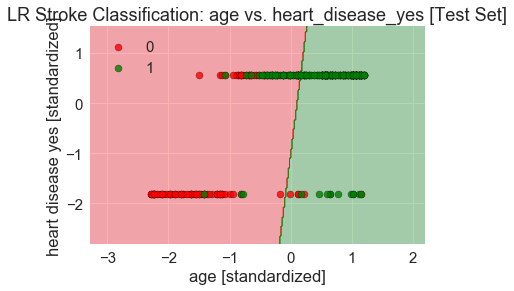

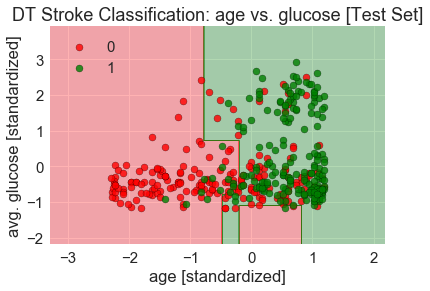

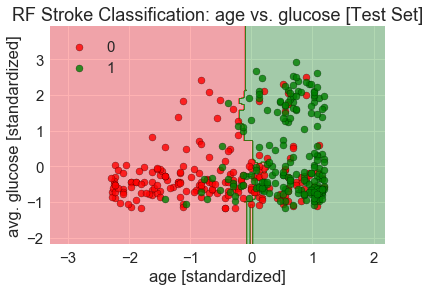

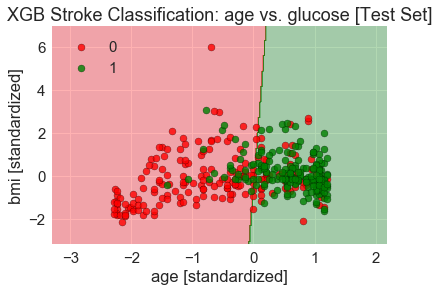

In [50]:
###########################################
# Decision Boundary Plots: ML Classifiers #
###########################################
# Write plot_decision_regions function #
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # Setup marker generator and colormap
    markers = ('o','o','s','^','v')
    colors = ('red','green','blue','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # Plot decision surface
    x1_min, x1_max = X[:,0].min()-1, X[:,0].max()+1
    x2_min, x2_max = X[:,1].min()-1, X[:,1].max()+1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl, edgecolor='black')

# Visualize stroke classification: Logistic Regression #
###############################################################################
# hold-out test set
plt.figure()
plot_decision_regions(X=X_test_lr, y=y_test, classifier=random_search_lr, test_idx=None)
plt.title('LR Stroke Classification: age vs. heart_disease_yes [Test Set]')
plt.xlabel('age [standardized]')
plt.ylabel('heart disease yes [standardized]')
plt.legend(loc='upper left')
plt.show()      

# Visualize stroke classification: Decision Tree #
###############################################################################
# hold-out test set
plt.figure()
plot_decision_regions(X=X_test_dt, y=y_test, classifier=random_search_dt, test_idx=None)
plt.title('DT Stroke Classification: age vs. glucose [Test Set]')
plt.xlabel('age [standardized]')
plt.ylabel('avg. glucose [standardized]')
plt.legend(loc='upper left')
plt.show()

# Visualize stroke classification: Random Forest #
###############################################################################
# hold-out test set
plt.figure()
plot_decision_regions(X=X_test_rf, y=y_test, classifier=random_search_rf, test_idx=None)
plt.title('RF Stroke Classification: age vs. glucose [Test Set]')
plt.xlabel('age [standardized]')
plt.ylabel('avg. glucose [standardized]')
plt.legend(loc='upper left')
plt.show()    

# Visualize stroke classification: XGBoost #
###############################################################################
# hold-out test set
plt.figure()
plot_decision_regions(X=X_test_xgb, y=y_test, classifier=random_search_xgb, test_idx=None)
plt.title('XGB Stroke Classification: age vs. glucose [Test Set]')
plt.xlabel('age [standardized]')
plt.ylabel('bmi [standardized]')
plt.legend(loc='upper left')
plt.show()        

## Ensemble Learning: Majortiy Vote Classifier ##
The goal of ensemble methods is to combine different classifiers into a meta-classifier that has better generalizaion performance than each individual classifier for making predictions. Basically, this majority voting means that we select the class label that has been predicted by majority of classifiers, that is, received more than 50% of the votes. This term "majority voting" applies to binary class problems only which is in our case where class has only two labels (i.e., non-stroke andd stroke).

For our case, we were able to train four different classifiers:
1. Logistic Regression
2. Decision Tree
3. Random Forest (ensemble learning: bagging)
4. XGBoost (gradient boosting)

A strong meta-classifier was built to balances out the individual classifiers' weaknesses on particular observations.


In [51]:
#######################################
# Implementing MajorityVoteClassifier #
#######################################
class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [52]:
# Test MajorityVoteClassifiers #
mv_clf = MajorityVoteClassifier(classifiers=[random_search_lr, random_search_dt,
                                            random_search_rf, random_search_xgb])
clf_labels = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
clf_labels += ['Majority Voting']         
all_clf = [random_search_lr, random_search_dt, random_search_rf, random_search_xgb, mv_clf]

# Model prediction: hold-out test set
y_pred_test_mv = mv_clf.fit(X_train_std,y_train).predict(X_test_std)

## Model Evaluation: Confusion Matrix ##
A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.

1. True Positives (TP): These are cases in which we predicted yes (they have the disease), and they do have the disease.
2. True Negatives (TN): We predicted no, and they don't have the disease.
3. False Positives (FP): We predicted yes, but they don't actually have the disease. (Also known as a "Type I error.")
4. False Negatives (FN): We predicted no, but they actually do have the disease. (Also known as a "Type II error.")

In [53]:
# Making the Confusion/Contingency Matrix #
###############################################################################
# Write plot_confusion_matrix function #
def plot_confusion_matrix(cm, classes):
    fig, ax = plt.subplots(figsize=(5,5))
    cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + cm.sum(axis=1)[:, np.newaxis])
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i,j], fmt), ha='center', va='center',
                    color='white' if cm[i,j] > thresh else 'black')    
        
    #plt.tight_layout()
    plt.xlabel('predicted label')
    plt.ylabel('true label')


# Make class labels for "stroke"
class_labels = np.array(['non-stroke','stroke'], dtype=str)        

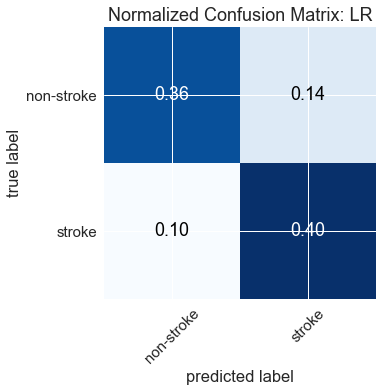

Accuracy of LogisticRegression is 0.77
Precision of LogisticRegression is 0.75
Recall of LogisticRegression is 0.81
ROC score of LogisticRegression is 0.77


In [54]:
# Plot confusion matrix on test set: Logistic Regression
###############################################################################
cm_test_lr = confusion_matrix(y_test, y_pred_test_lr)
np.set_printoptions(precision=2)  

plot_confusion_matrix(cm_test_lr, class_labels)
plt.title('Normalized Confusion Matrix: LR')
plt.show()

# Classification metrics on test set: LogisticRegression
print('Accuracy of LogisticRegression is %0.2f'% accuracy_score(y_test, y_pred_test_lr))
print('Precision of LogisticRegression is %0.2f'% precision_score(y_test, y_pred_test_lr))
print('Recall of LogisticRegression is %0.2f'% recall_score(y_test, y_pred_test_lr))
print('ROC score of LogisticRegression is %0.2f'% roc_auc_score(y_test, y_pred_test_lr))

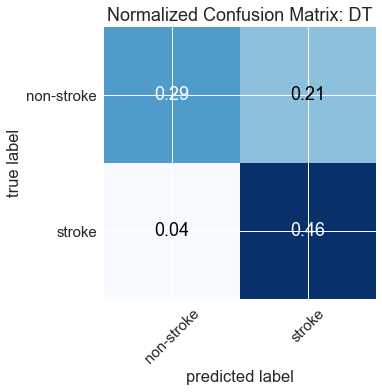

Accuracy of DecisionTree is 0.75
Precision of DecisionTree is 0.68
Recall of DecisionTree is 0.93
ROC score of DecisionTree is 0.75


In [55]:
# Plot confusion matrix on test set: DecisionTree
###############################################################################
cm_test_dt = confusion_matrix(y_test, y_pred_test_dt)  
np.set_printoptions(precision=2)  

plot_confusion_matrix(cm_test_dt, class_labels)
plt.title('Normalized Confusion Matrix: DT')
plt.show()

# Classification metrics on test set: DecisionTree
print('Accuracy of DecisionTree is %0.2f'% accuracy_score(y_test, y_pred_test_dt))
print('Precision of DecisionTree is %0.2f'% precision_score(y_test, y_pred_test_dt))
print('Recall of DecisionTree is %0.2f'% recall_score(y_test, y_pred_test_dt))
print('ROC score of DecisionTree is %0.2f'% roc_auc_score(y_test, y_pred_test_dt))  

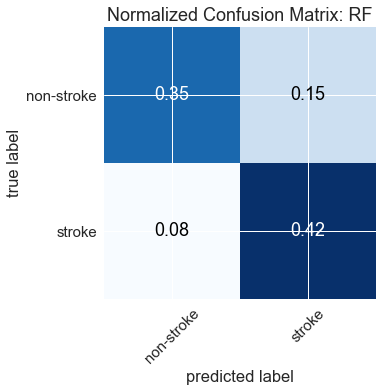

Accuracy of RandomForest is 0.77
Precision of RandomForest is 0.73
Recall of RandomForest is 0.84
ROC score of RandomForest is 0.77


In [56]:
# Plot confusion matrix on test set: RandomForest
###############################################################################
cm_test_rf = confusion_matrix(y_test, y_pred_test_rf)  
np.set_printoptions(precision=2)  

plot_confusion_matrix(cm_test_rf, class_labels)
plt.title('Normalized Confusion Matrix: RF')
plt.show()

# Classification metrics on test set: RandomForest
print('Accuracy of RandomForest is %0.2f'% accuracy_score(y_test, y_pred_test_rf))
print('Precision of RandomForest is %0.2f'% precision_score(y_test, y_pred_test_rf))
print('Recall of RandomForest is %0.2f'% recall_score(y_test, y_pred_test_rf))
print('ROC score of RandomForest is %0.2f'% roc_auc_score(y_test, y_pred_test_rf))

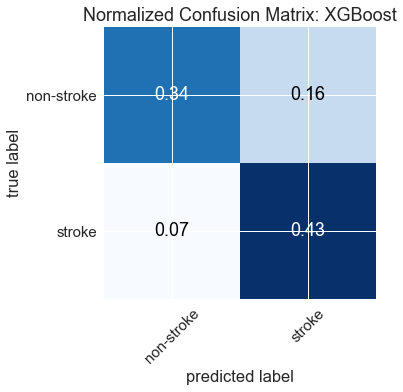

Accuracy of XGBoost is 0.77
Precision of XGBoost is 0.73
Recall of XGBoost is 0.86
ROC score of XGBoost is 0.77


In [57]:
# Plot confusion matrix on test set: XGBoost
###############################################################################
cm_test_xgb = confusion_matrix(y_test, y_pred_test_xgb) 
np.set_printoptions(precision=2)  

plot_confusion_matrix(cm_test_xgb, class_labels)
plt.title('Normalized Confusion Matrix: XGBoost')
plt.show()

# Classification metrics on test set: XGBoost
print('Accuracy of XGBoost is %0.2f'% accuracy_score(y_test, y_pred_test_xgb))
print('Precision of XGBoost is %0.2f'% precision_score(y_test, y_pred_test_xgb))
print('Recall of XGBoost is %0.2f'% recall_score(y_test, y_pred_test_xgb))
print('ROC score of XGBoost is %0.2f'% roc_auc_score(y_test, y_pred_test_xgb))

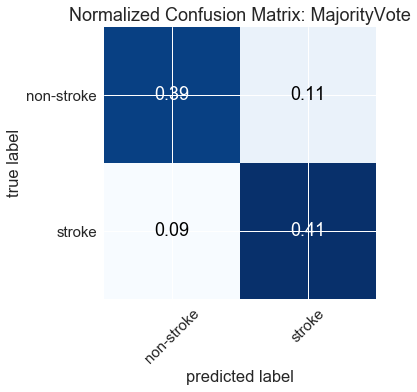

Accuracy of MajorityVote is 0.80
Precision of MajorityVote is 0.78
Recall of MajorityVote is 0.82
ROC score of MajorityVote is 0.80


In [58]:
# Plot confusion matrix on test set: MajorityVote
###############################################################################
cm_test_mv = confusion_matrix(y_test, y_pred_test_mv) 
np.set_printoptions(precision=2)  

plot_confusion_matrix(cm_test_mv, class_labels)
plt.title('Normalized Confusion Matrix: MajorityVote')
plt.show()

# Classification metrics on test set: MajorityVote
print('Accuracy of MajorityVote is %0.2f'% accuracy_score(y_test, y_pred_test_mv))
print('Precision of MajorityVote is %0.2f'% precision_score(y_test, y_pred_test_mv))
print('Recall of MajorityVote is %0.2f'% recall_score(y_test, y_pred_test_mv))
print('ROC score of MajorityVote is %0.2f'% roc_auc_score(y_test, y_pred_test_mv))

## Model Evaluation: precision-recall curve ##
Precision-Recall is a useful measure of success for predictions when the classes of dataset are highly imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

The precision-recall curve shows the tradeoff between precision and recall at different thresholds. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

In summary, a system with high recall but low precision returns: many predictions where most of prediction results are incorrect when compared to actual true labels. Conversely, a system with low recall and high precision returns: few predictions but most of its prediction results are correct when compared to actual true labels.

Average precision-recall score of MajorityVote model: 0.82


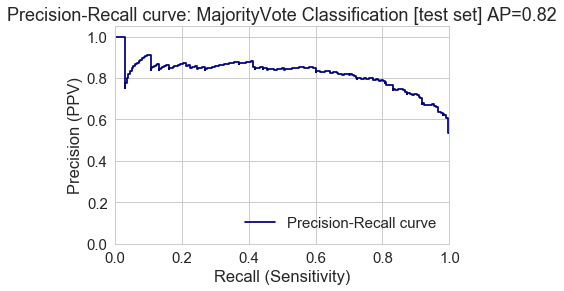

In [59]:
############################################
# Model Evaluation: Precision Recall Curve #
############################################
# Compute average precision score:
###############################################################################
y_score_mv = mv_clf.fit(X_train_std,y_train).predict_proba(X_test_std)[:,1]
avg_precision = average_precision_score(y_test, y_score_mv)

print('Average precision-recall score of MajorityVote model: {0:0.2f}'.format(
      avg_precision))

# Plot Precision-Recall curve:
###############################################################################
precision, recall, _ = precision_recall_curve(y_test, y_score_mv)

sns.set_style('whitegrid')

plt.step(recall, precision, color='navy', where='post',label='Precision-Recall curve')
#plt.fill_between(recall, precision, step='post', alpha=0.2, color='navy')
plt.title('Precision-Recall curve: MajorityVote Classification [test set] AP={0:0.2f}'
          .format(avg_precision))
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc='lower right')
plt.show()

## Model Evaluation: ROC curve ##

ROC curve typically displays true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better. The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

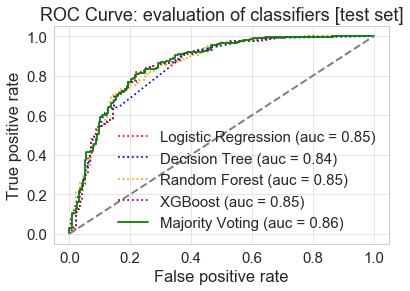

In [60]:
###################################
# Model Evaluation: ROC-AUC Curve #
###################################
# Plot a ROC Curve #
# ROC for each classifiers
colors = ['red', 'blue', 'orange', 'purple', 'green']
linestyles = [':', ':', ':', ':', '-']
for clf, label, clr, ls \
    in zip(all_clf, clf_labels, colors, linestyles):
        # Asumming the label of the positive class is 1
        y_pred = clf.fit(X_train_std,
                         y_train).predict_proba(X_test_std)[:,1]
        fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                         y_score=y_pred)
        roc_auc = auc(x=fpr, y=tpr)
        plt.plot(fpr, tpr, color=clr, linestyle=ls,
                 label='%s (auc = %0.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1], [0,1],linestyle='--',color='gray',linewidth=2)    
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve: evaluation of classifiers [test set]')
plt.show()